In [39]:
from platform import python_version
print("Python: " + python_version())
import tensorflow as tf
print("Tensorflow: " + tf.__version__)
from tensorflow import keras
from os import walk
import numpy as np
from os import walk
import time
import matplotlib
from matplotlib import pyplot as plt
import cv2  #OpenCV 
import os
import glob
import pandas as pd
import regex as re
import h5py

Python: 3.9.0
Tensorflow: 2.7.0


__Global Variables__

In [40]:
SD_imbalance_hdf5 = "D:/UoH_PhD_Exp/Data/Data_HDF/SD_Imbalanced_Data.h5"
SD_balance_hdf5 = "D:/UoH_PhD_Exp/Data/Data_HDF/SD_balanced_Data.h5"

__GPU Configuration__

In [41]:
import warnings

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found")
else:
    print("Default GPU device: {}".format(tf.test.gpu_device_name()))
    
print("Num Devices Available: ", len(tf.config.experimental.list_physical_devices()))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Default GPU device: /device:GPU:0
Num Devices Available:  2
Num CPUs Available:  1
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2191391708566967372
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2909195470
locality {
  bus_id: 1
  links {
  }
}
incarnation: 916393876983133577
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


__Read HDF5 Data__

In [42]:
def read_many_hdf5(num_images, file_path):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(file_path, "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

__Loss Accuracy Curve__

In [43]:
def loss_accuracy_curves(history):
    ############### printing accuracy and loss between the epoches #########
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label ="Validation")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label ="Validation")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

__Ostu Thresholding/Binarisation__

In [44]:
def ostu_thd(XX):
    rnd_images = []
    for img in XX:
        #img = rgb2gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Otsu's thresholding
        ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        rnd_images.append(th2)
    test_images = np.array(rnd_images)
    
    return test_images

__Train and Test Split + Reshaping Data to adjust greyscal dimension__

In [45]:
import scipy._lib
from sklearn.model_selection import train_test_split

def pre_process(X, y):
    
    # test_size is the test size of the total dataset, random_state controls the shuffling of data. same state returns same data always.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=786, stratify=y) 
    print("Total training intences: " + str(len(y_train)))
    print("Train Data:" + str(np.unique(y_train, return_counts=True)))
    print("Total testing intences: " + str(len(y_test)))
    print("Test Data:" + str(np.unique(y_test, return_counts=True)))

    print("Before Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    # reshape to be [samples][width][height][channels]
    X_train = X_train.reshape((X_train.shape[0], 58, 120, 1))
    X_test = X_test.reshape((X_test.shape[0], 58, 120, 1))
    print("After Reshaping the shape of train and test dataset:")
    print(X_train.shape)
    print(X_test.shape)
    
    # Convert the array to float32 as opposed to uint8
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
    X_train /= 255
    X_test /=  255

    NUM_DIGITS = 2

    print("Before", y_train[0]) # The format of the labels before conversion

    y_train  = tf.keras.utils.to_categorical(y_train, NUM_DIGITS)

    print("After", y_train[0]) # The format of the labels after conversion

    y_test = tf.keras.utils.to_categorical(y_test, NUM_DIGITS)
    
    return X_train, X_test, y_train, y_test

## Model

__Model3__

In [46]:
def model_3c3p1f2d1d_modified():
    
    np.random.seed(786)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(58, 120,1)))
    model.add(tf.keras.layers.MaxPool2D(strides=2))
    model.add(tf.keras.layers.Conv2D(filters=80, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=2))
    model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(320, activation=tf.nn.relu))#, input_shape=(28500,)))
    model.add(tf.keras.layers.Dense(280, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

    # We will now compile and print out a summary of our model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

    print(model.summary())
    return model

## Main Execution Body

Total X intences: (5460, 58, 120)
Total y intences: 5460
Total Normal images in balanced dataset: 2868
Total distorted images in balanced dataset: 2592
Total training intences: 3822
Train Data:(array([0, 1], dtype=uint8), array([2008, 1814], dtype=int64))
Total testing intences: 1638
Test Data:(array([0, 1], dtype=uint8), array([860, 778], dtype=int64))
Before Reshaping the shape of train and test dataset:
(3822, 58, 120)
(1638, 58, 120)
After Reshaping the shape of train and test dataset:
(3822, 58, 120, 1)
(1638, 58, 120, 1)
Before 0
After [1. 0.]
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 58, 120, 32)       832       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 29, 60, 32)       0         
 g2D)                                                            
                          

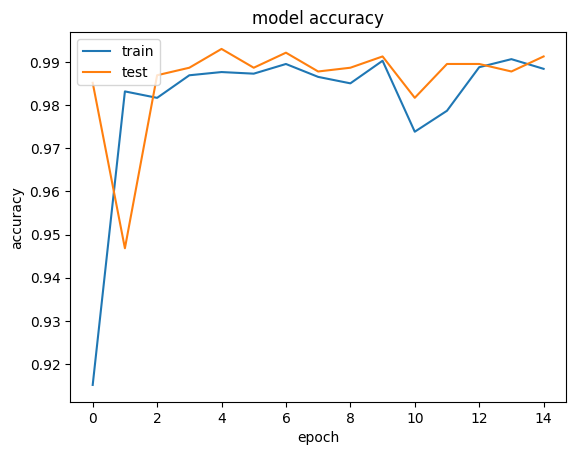

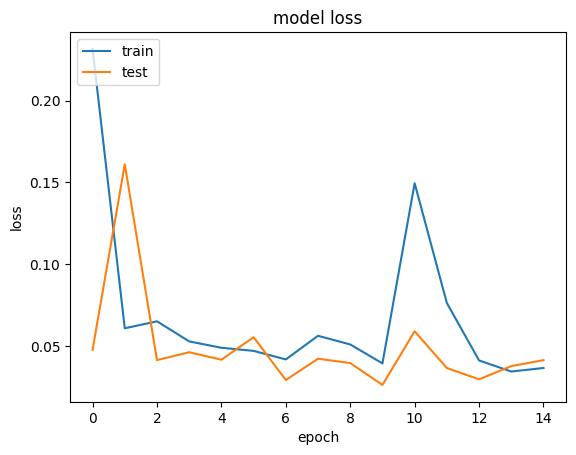

In [47]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping

############ read Dataset
X, y = read_many_hdf5(0,SD_balance_hdf5)
print("Total X intences: " + str(X.shape))
print("Total y intences: " + str(len(y)))
my_class, my_count = np.unique(y, return_counts=True)
print("Total Normal images in balanced dataset: " + str(my_count[0]))
print("Total distorted images in balanced dataset: " + str(my_count[1]))

############ Train-Test Split + Data Pre processing
X_train, X_test, y_train, y_test = pre_process(X,y)
############ Model
model3 = model_3c3p1f2d1d_modified()
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
############ Fit Model
#model.fit(samples_cnn, dataset.labels, epochs=epochs, batch_size=batch_size, verbose=1)
history3 = model3.fit(X_train, y_train, batch_size=10, epochs=40,verbose=1, validation_split=0.3, callbacks=[es])#, class_weight=my_class_weight)
print(history3)
########### Evaluate model
loss3, accuracy3 = model3.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy3))
print('Test loss: %.2f' % (loss3))
########## Classification Report
y_pred3 = model3.predict(X_test)
y_actual3 = np.argmax(y_test,axis=1)
print(y_actual3[0:25])
y_pred3 = np.argmax(y_pred3,axis=1)
print(y_pred3[0:25])

print(classification_report(y_actual3,y_pred3))
print(confusion_matrix(y_actual3,y_pred3))
print(accuracy_score(y_actual3,y_pred3))

################# PLot Loss accuracy curves
loss_accuracy_curves(history3)

# Model Debugging

## 1. Filter plotting of CNN model

In [48]:
for layer in model3.layers:
    #print(layer.name)
    if 'dense' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
        #print(filters)
        output = layer.output
        print(output)
    elif 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
    elif 'max' or 'flatten' in layer.name:
        continue

conv2d_24 (5, 5, 1, 32)
conv2d_25 (3, 3, 32, 80)
conv2d_26 (2, 2, 80, 48)
dense_24 (5040, 320)
KerasTensor(type_spec=TensorSpec(shape=(None, 320), dtype=tf.float32, name=None), name='dense_24/Relu:0', description="created by layer 'dense_24'")
dense_25 (320, 280)
KerasTensor(type_spec=TensorSpec(shape=(None, 280), dtype=tf.float32, name=None), name='dense_25/Relu:0', description="created by layer 'dense_25'")
dense_26 (280, 2)
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense_26/Softmax:0', description="created by layer 'dense_26'")


__Plotting the first six filters from the first hidden convolutional layer in the model__

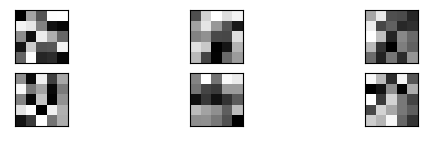

In [49]:
from matplotlib import pyplot
filters, biases = model3.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
# get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

## 2. Feature map plotting of Convo layers

In [50]:
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import Model
def visualise_CNN(img):
    
    # redefine model to output right after the first hidden layer
    ixs = [0,2,4]
    outputs = [model3.layers[i].output for i in ixs]
    model = Model(inputs=model3.inputs, outputs=outputs)
    # load the image with the required shape

    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    
    square = 5
    convo_layer = 1
    for fmap in feature_maps:
        print("Feature map of convo layer: " + str(convo_layer))
        convo_layer+=1
        # plot all 64 maps in an 8x8 squares
        ix = 1
        for _ in range(square):
            for _ in range(square):
                # specify subplot and turn of axis
                ax = pyplot.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1
        # show the figure
        pyplot.show()

(58, 120)
(1, 58, 120, 1)
Feature map of convo layer: 1


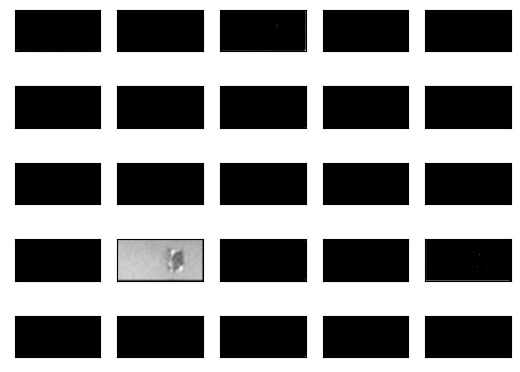

Feature map of convo layer: 2


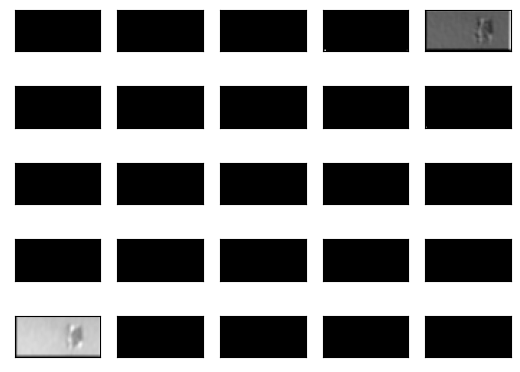

Feature map of convo layer: 3


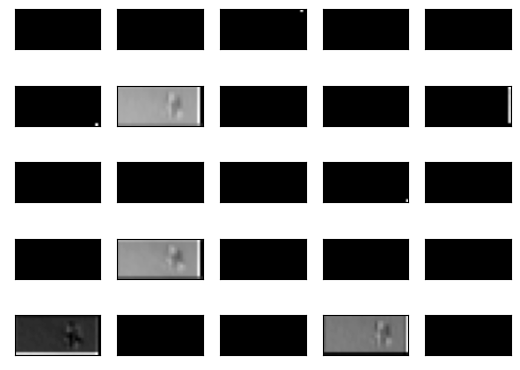

In [51]:
img2 = cv2.imread("D:/UoH_PhD_Exp/Data/SD_crop_images/1_440_cube_1_PB_ExposureEnd.jpg")
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
print(img2.shape)
img2 = img2.reshape(58, 120, 1)
#print(img2.shape)
img2 = expand_dims(img2, axis=0)
print(img2.shape)
visualise_CNN(img2)

Feature map of convo layer: 1


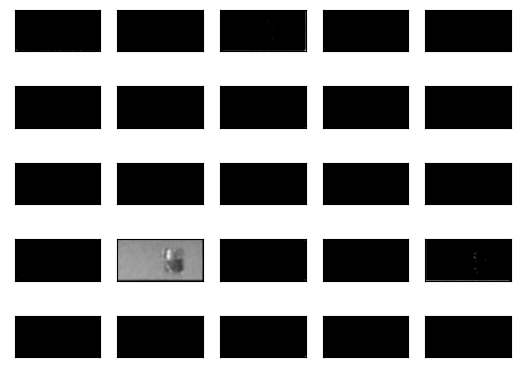

Feature map of convo layer: 2


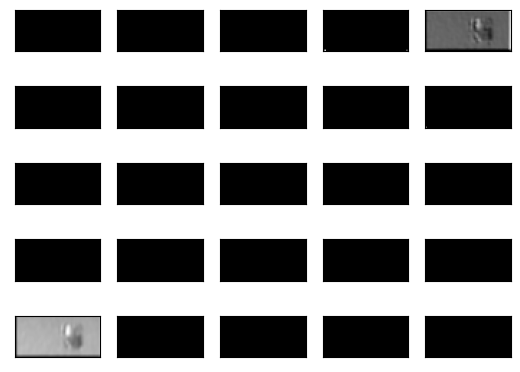

Feature map of convo layer: 3


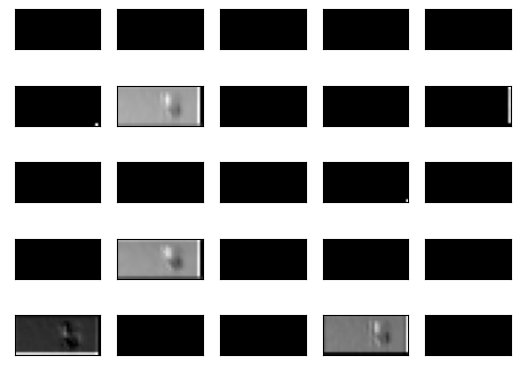

In [52]:
img2 = cv2.imread("D:/UoH_PhD_Exp/Data/SD_crop_images/1_445_cube_1_PB_ExposureEnd.jpg")
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img2 = img2.reshape(58, 120, 1)
img2 = expand_dims(img2, axis=0)
visualise_CNN(img2)

Feature map of convo layer: 1


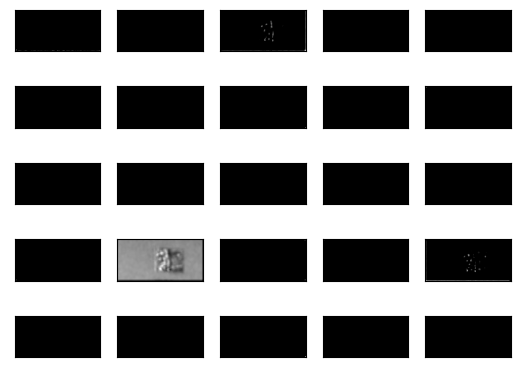

Feature map of convo layer: 2


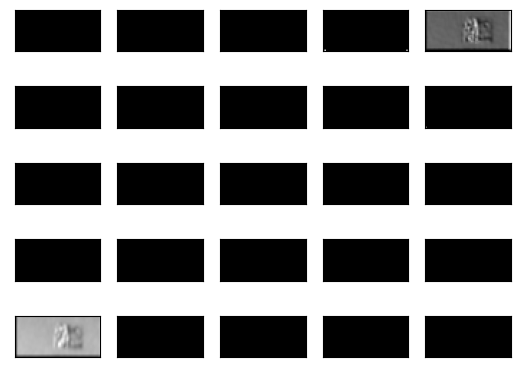

Feature map of convo layer: 3


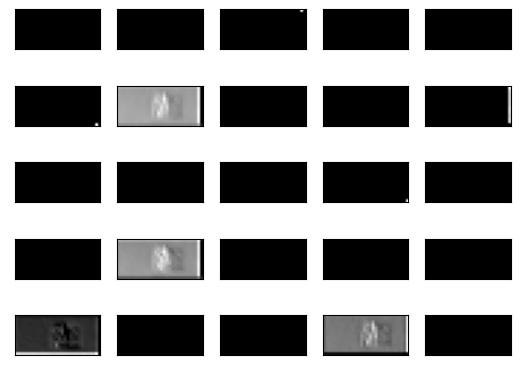

In [53]:
img2 = cv2.imread("D:/UoH_PhD_Exp/Data/SD_crop_images/1_453_cube_1_PB_ExposureEnd.jpg")
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img2 = img2.reshape(58, 120, 1)
img2 = expand_dims(img2, axis=0)
visualise_CNN(img2)

Feature map of convo layer: 1


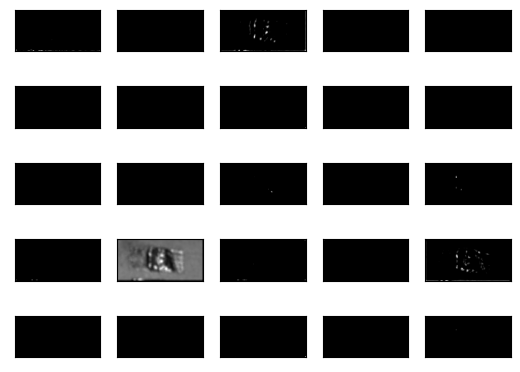

Feature map of convo layer: 2


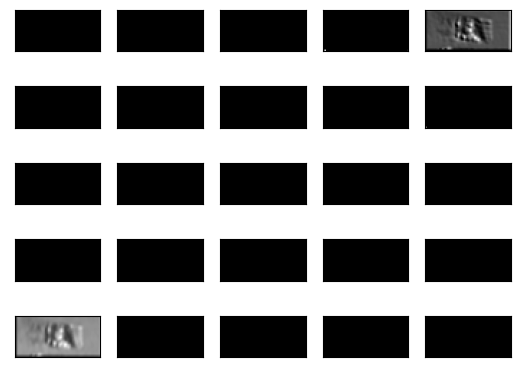

Feature map of convo layer: 3


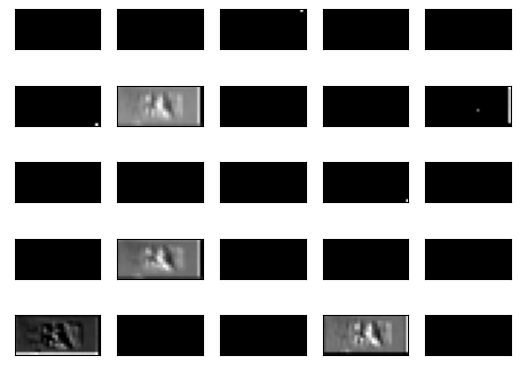

In [54]:
img2 = cv2.imread("D:/UoH_PhD_Exp/Data/SD_crop_images/1_500_cube_1_PB_ExposureEnd.jpg")
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img2 = img2.reshape(58, 120, 1)
img2 = expand_dims(img2, axis=0)
visualise_CNN(img2)

Feature map of convo layer: 1


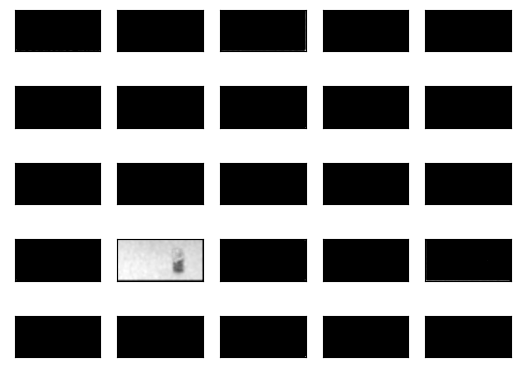

Feature map of convo layer: 2


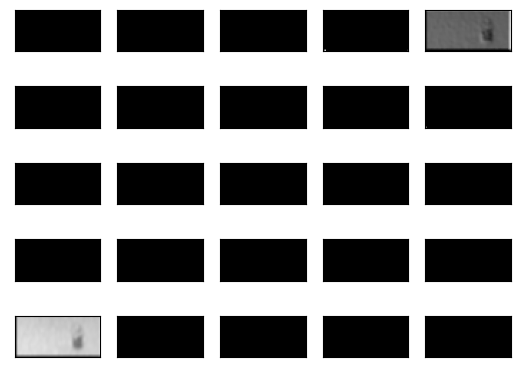

Feature map of convo layer: 3


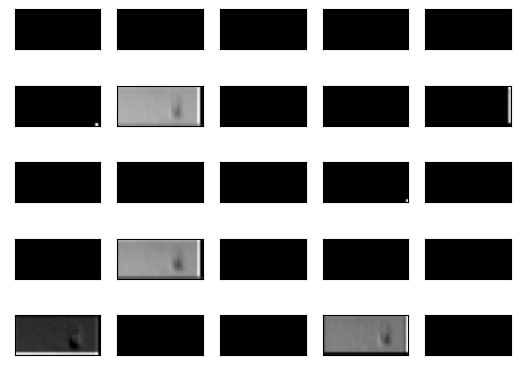

In [55]:
img2 = cv2.imread("D:/UoH_PhD_Exp/Data/SD_crop_images/0_300_cube_1_PB_ExposureEnd.jpg")
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img2 = img2.reshape(58, 120, 1)
img2 = expand_dims(img2, axis=0)
visualise_CNN(img2)